In [93]:
import h5py
import numpy
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from pandas import read_csv
import pandas as pd
from sklearn.neural_network import MLPClassifier
from numpy import mean, array
import time
import random
import os
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib as mpl

In [94]:
#functions
#make enzyme:substrate list from h5 embeddings and smiles files
def makePairs(embedding, smiles):
    reduced_file = h5py.File(embedding)
    genes, substrate = list(), list()
    for key in list(reduced_file.keys()):
        for item in smiles["Substrate"]:
            genes.append(key)
            substrate.append(item)
    pair_list = pd.DataFrame({"Gene":genes, "Substrate": substrate})
    return(pair_list)

#making embbeding df
def T5_match(reduced_embedding, long_df):
    reduced_file = h5py.File(reduced_embedding, "r")
    seq_embeddings = numpy.empty(1024)
    for item in long_df["Gene"]:
        #res = [key for key, val in indexes.items() if item  in val]
        array = numpy.asarray(reduced_file[item])
        #removinf nans
        array = numpy.nan_to_num(array, nan=0.0)
        seq_embeddings = numpy.vstack((seq_embeddings,array))
    seq_embeddings = seq_embeddings[1:]
    end_time = time.perf_counter()
    return seq_embeddings    
#matching embedding with Gene name in pooled embeddings


def substrate_match(long_df, descriptors, smiles):
    subs_descriptors = numpy.empty(167)
    for item in long_df['Substrate']:
        #print(item)
        index = smiles.index[smiles["Substrate"]==item][0]
        subs_descriptors = numpy.vstack((subs_descriptors, descriptors[index]))
    subs_descriptors = subs_descriptors[1:]
    return subs_descriptors
#function for substrate embedding generation
def substrate_descriptor(smiles):
    substrate_desc = numpy.empty(167)
    for item in smiles['SMILES']:
        #print(item.index())
        mol = Chem.MolFromSmiles(item)
        fp =  Chem.MACCSkeys.GenMACCSKeys(mol)
        array = numpy.zeros((0, ), dtype=numpy.int8)
        DataStructs.ConvertToNumpyArray(fp, array)
        substrate_desc = numpy.vstack((substrate_desc, array))

    substrate_desc = substrate_desc[1:]
    return substrate_desc

#make ML df for training
def makeMLset(adress, smiles):
    input_df = makePairs(adress, smiles)
    fingerprints = substrate_descriptor(smiles)
    embeddings = T5_match(adress, input_df)    
    substrate_fp = substrate_match(input_df, fingerprints, smiles)
    X = numpy.hstack((embeddings,  substrate_fp))
    return(X)

#training model for prediction export using MACCS/Prottrans and MLP 
def make_prediction(embedding, smiles,outfile, model_name):
    input_X = makeMLset(embedding, smiles)
    input_df = makePairs(embedding, smiles)
    models = list()
    for x in os.listdir("../models/"  + model_name):
        if x.endswith(".sav"):
            models.append(x)
    score = list()
    y_pred = list()
    for i in models:
        score_clf = list()
        clf = pickle.load(open('../models/' + model_name + "/" +i, 'rb'))
        y_pred.append(clf.predict(input_X))
    out_df = input_df[["Gene", "Substrate"]] 
    out_df["pred"] = list(mean(y_pred, axis = 0))
    out_df.to_csv(outfile, sep=";")
    return(out_df)

#training and saving model
def trainModel(smiles, input_df, embedding, model_name):
    cell_free_set = read_csv(input_df)
    smiles = read_csv(smiles)
    cell_free_embeddings = T5_match(embedding,cell_free_set)
    cell_free_substrates = substrate_match(cell_free_set, substrate_descriptor(smiles), smiles)
    X_cellfree = numpy.hstack((cell_free_embeddings,  cell_free_substrates))
    y_train = cell_free_set['value']
    models = list()
    for x in os.listdir("../models/" + model_name):
        if x.endswith(".sav"):
            models.append(x)
    if len(models) != 0:
        print("Models are already trained")
    else:
        for i in range(0,10):
            import random
            out_name = "../models/" + model_name + "/model" + str(i) + ".sav"
            RANDOM_STATE = random.randint(0, 10000)
            clf = MLPClassifier(max_iter=50000, random_state=RANDOM_STATE)
            clf.fit(X_cellfree, y_train)
            pickle.dump(clf, open(out_name, 'wb'))

#plot heatmap
def plotHeatmap(prediction_output):
    wide_output = pd.pivot(prediction_output, index = "Gene", columns = "Substrate", values = "pred")
    prediction = pd.DataFrame.to_numpy(wide_output)
    fig, ax = plt.subplots(figsize = (20,10))
    im = ax.imshow(prediction, cmap = "Blues")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(wide_output.columns.values)), labels=wide_output.columns.values,
                  rotation=90, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(wide_output.index.values)), labels=wide_output.index.values)

    # Loop over data dimensions and create text annotations.
    for j in range(len(wide_output.columns.values)):
        for i in range(len(wide_output.index.values)):
            text = ax.text(j, i, prediction[i, j],
                           ha="center", va="center", color="y")
    fig.tight_layout()
    plt.show()


In [81]:
#training compact model on Cell free dataset
trainModel("../input_data/smiles_combined.csv", "../input_data/T3PKS_cellfree_df.csv",
          '../input_data/T3PKS_embeddings.h5', "small")

Models are already trained


In [82]:
#training expanded model on Cell free dataset
trainModel("../input_data/smiles_combined.csv", "../input_data/T3PKS_full_dataset.csv",
          '../input_data/T3PKS_embeddings.h5', "expanded")

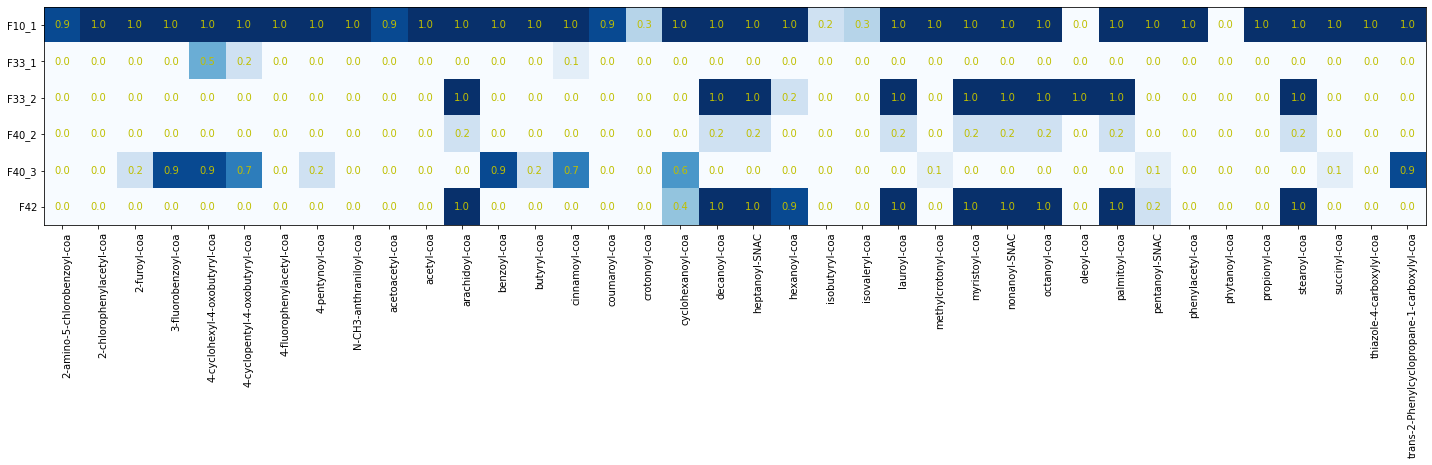

In [96]:
#Example 1: Prediction for 6 new enzymes with 38 substrates used in training
#run prediction with small model
new_fasta_out = make_prediction('../input_data/new_fasta.h5', 
                                smiles, "../output_data/new_fasta_prediction.csv", "small")
plotHeatmap(new_fasta_out)

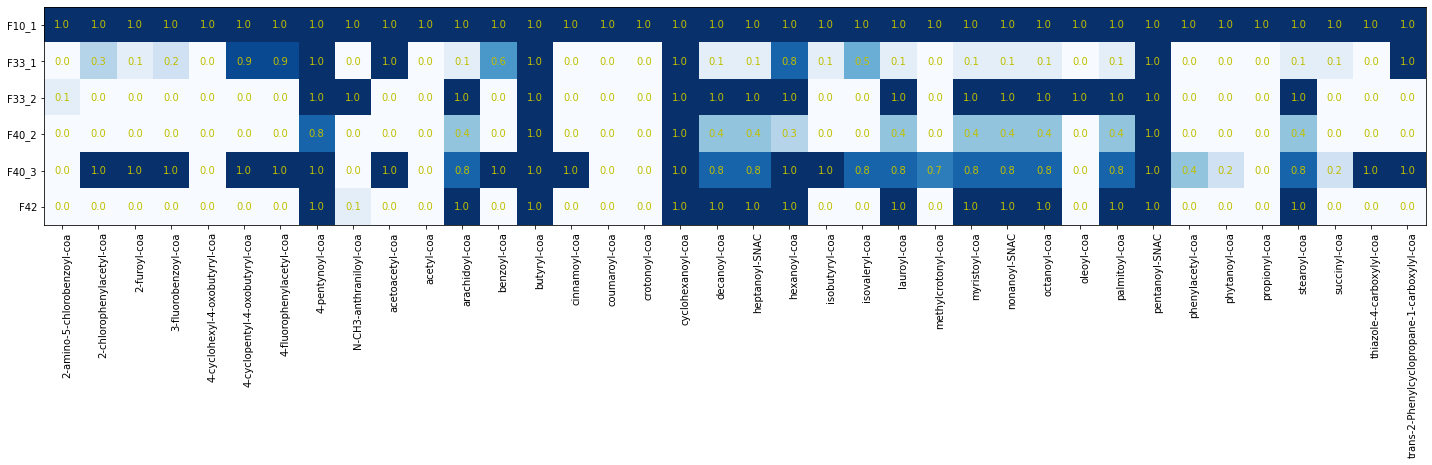

In [97]:
#Example 1: Prediction for 6 new enzymes with 38 substrates used in training
#run prediction with small model
new_fasta_out_expanded = make_prediction('../input_data/new_fasta.h5', 
                                smiles, "../output_data/new_fasta_prediction.csv", "expanded")
plotHeatmap(new_fasta_out_expanded)

In [38]:
#Example 2: making kingdom-wide prediction for 10 new substrates
#reading new smiles and calculation
new_smiles = read_csv("../input_data/new_smiles.csv", sep = ",")

#making prediction
X_substrates_prediction = makeMLset('../input_data/all_embeddings.h5', new_smiles)
all_fasta = make_prediction('../input_data/all_embeddings.h5', new_smiles, "../output_data/all_substrate_prediction.csv")

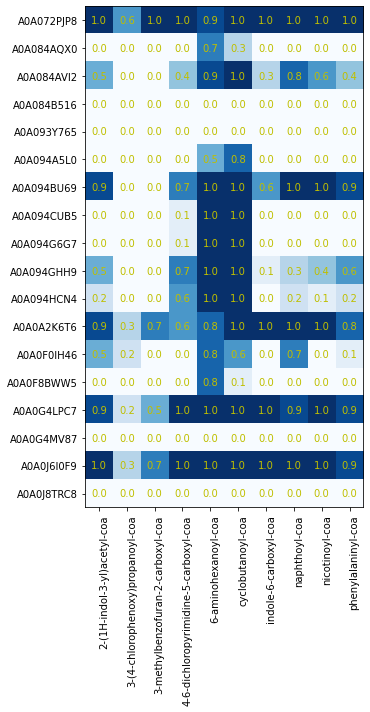

In [50]:
#visualising subset of results
all_fasta_df = pd.pivot(all_fasta, index = "Gene", columns = "Substrate", values = "pred")
prediction_2 = pd.DataFrame.to_numpy(all_fasta_df)

import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize = (20,10))
im = ax.imshow(prediction_2[0:18,0:10], cmap = "Blues")

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(all_fasta_df.columns.values[0:10])), labels=all_fasta_df.columns.values[0:10],
              rotation=90, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(all_fasta_df.index.values[0:18])), labels=all_fasta_df.index.values[0:18])

# Loop over data dimensions and create text annotations.
for j in range(len(all_fasta_df.columns.values[0:10])):
    for i in range(len(all_fasta_df.index.values[0:18])):
        text = ax.text(j, i, prediction_2[i, j],
                       ha="center", va="center", color="y")
fig.tight_layout()
plt.show()